
Viscoplastic thermal convection in a 2-D square box
=======

Benchmarks from Tosi et al. 2015
--------



This notebook generates models from the <a name="ref-1"/>[(Tosi et al., 2015)](#cite-tosi2015community) in Underworld2. The Underworld2 results are compared to the model run on Fenics. Input files for the Fenics models were provided by Petra Maierova.

This example uses the RT PIC solver with classic and nearest neighbour


References
====

<a name="cite-tosi2015community"/><sup>[^](#ref-1) </sup>Tosi, Nicola and Stein, Claudia and Noack, Lena and H&uuml;ttig, Christian and Maierov&aacute;, Petra and Samuel, Henri and Davies, DR and Wilson, CR and Kramer, SC and Thieulot, Cedric and others. 2015. _A community benchmark for viscoplastic thermal convection in a 2-D square box_.



In [1]:
#pwd

Load python functions needed for underworld. Some additional python functions from os, math and numpy used later on.

In [2]:
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import matplotlib.pyplot as pyplot
import time
import numpy as np
import os
import sys

from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [3]:
############
#Need to manually set these two
############
Model = "T"
ModNum = 0

if len(sys.argv) == 1:
    ModIt = "Base"
elif sys.argv[1] == '-f':
    ModIt = "Base"
else:
    ModIt = str(sys.argv[1])


Set physical constants and parameters, including the Rayleigh number (*RA*). 

In [4]:
#Do you want to write hdf5 files - Temp, RMS, viscosity, stress?
writeFiles = True

In [5]:
ETA_T = 1e5
newvisc= math.exp(math.log(ETA_T)*0.53)


In [6]:
###########
#Constants
###########
RA  = 1e2*newvisc       # Rayleigh number
TS  = 0          # surface temperature
TB  = 1          # bottom boundary temperature (melting point)
ETA_T = 1e5
ETA_Y = 10
ETA0 = 1e-3*newvisc
RES = 40
YSTRESS = 1.*newvisc
D = 2890.
MAXY = 1.2

In [7]:
##########
#variables, these can be defined with STDIN,
##########
#The == '-f': check is just to check if we're running a notebook - careful, haven't tested
    
#Watch the type assignemnt on sys.argv[1]

DEFAULT = 128
    
if len(sys.argv) == 1:
    RES = DEFAULT
elif sys.argv[1] == '-f':
    RES = DEFAULT
else:
    RES = int(sys.argv[1])
    

In [8]:
outputPath = str(Model) + "/" + str(ModNum) + "/"
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '_' + str(ModIt) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(checkpointPath):
        os.makedirs(checkpointPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)

In [9]:
dim = 2          # number of spatial dimensions

Xres, Yres = RES, RES
dim = 2          # number of spatial dimensions

In [10]:
yelsize = MAXY/Yres
yelsize*D

27.09375

Select which case of viscosity from Tosi et al (2015) to use. Adjust the yield stress to be =1 for cases 1-4, or between 3.0 and 5.0 (in increments of 0.1) in case 5.

Set output file and directory for results

Create mesh objects. These store the indices and spatial coordiates of the grid points on the mesh.

In [11]:
elementMesh = uw.mesh.FeMesh_Cartesian( elementType=("Q1/dQ0"), 
                                         elementRes=(Xres, Yres), 
                                           minCoord=(0.,0.), 
                                           maxCoord=(1.,MAXY)  )
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh 

Create Finite Element (FE) variables for the velocity, pressure and temperature fields. The last two of these are scalar fields needing only one value at each mesh point, while the velocity field contains a vector of *dim* dimensions at each mesh point.

In [12]:
velocityField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=dim )
pressureField    = uw.fevariable.FeVariable( feMesh=constantMesh, nodeDofCount=1 )
temperatureField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1 )

Create some dummy fevariables for doing top and bottom boundary calculations.

#ICs and BCs

In [13]:
# Initialise data.. Note that we are also setting boundary conditions here
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
temperatureField.data[:] = 0.

# Setup temperature initial condition via numpy arrays
A = 0.01
#Note that width = height = 1
tempNump = temperatureField.data
for index, coord in enumerate(linearMesh.data):
    pertCoeff = (1- coord[1]) + A*math.cos( math.pi * coord[0] ) * math.sin( math.pi * coord[1] )
    tempNump[index] = pertCoeff;
    if coord[1] > 1:
        tempNump[index] = 0.
    

    

In [14]:
#import h5py 
#tempfile2 = h5py.File('../../TosiOutput/files/temperatureField_4_3800.hdf5', libver='latest') 
#tempfile2 = tempfile2["data"][:] 
#temperatureField.data[:] = tempfile2

In [15]:
# Get the actual sets 
#
#  HJJJJJJH
#  I      I
#  I      I
#  I      I
#  HJJJJJJH
#  
#  Note that H = I & J 

# Note that we use operator overloading to combine sets
IWalls = linearMesh.specialSets["MinI_VertexSet"] + linearMesh.specialSets["MaxI_VertexSet"]
JWalls = linearMesh.specialSets["MinJ_VertexSet"] + linearMesh.specialSets["MaxJ_VertexSet"]
TWalls = linearMesh.specialSets["MaxJ_VertexSet"]
BWalls = linearMesh.specialSets["MinJ_VertexSet"]

In [16]:
# Now setup the dirichlet boundary condition
# Note that through this object, we are flagging to the system 
# that these nodes are to be considered as boundary conditions. 
# Also note that we provide a tuple of sets.. One for the Vx, one for Vy.
freeslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              nodeIndexSets=(IWalls,JWalls) )

# also set dirichlet for temp field
tempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              nodeIndexSets=(JWalls,) )

In [17]:
# Set temp boundaries 
# on the boundaries
for index in linearMesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = TB
for index in linearMesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = TS

#Particles

In [18]:
# We create swarms of particles which can advect, and which may determine 'materials'
gSwarm = uw.swarm.Swarm( feMesh=elementMesh )

# Now we add a data variable which will store an index to determine material
materialVariable = gSwarm.add_variable( dataType="char", count=1 )
tempVariableVis = gSwarm.add_variable( dataType="float", count=1 )
rockIntVar = gSwarm.add_variable( dataType="double", count=1 )
airIntVar = gSwarm.add_variable( dataType="double", count=1 )
lithIntVar = gSwarm.add_variable( dataType="double", count=1 )


# Layouts are used to populate the swarm across the whole domain
# Create the layout object
layout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=gSwarm, particlesPerCell=50 )
# Now use it to populate.
gSwarm.populate_using_layout( layout=layout )


# Lets initialise the 'materialVariable' data to represent different materials.

temp = temperatureField.evaluate(gSwarm)
tempVariableVis.data[:] = temp[:]



mantleIndex = 0
lithosphereIndex = 1
crustIndex = 2
airIndex = 3


# Set the material to heavy everywhere via the numpy array
materialVariable.data[:] = mantleIndex


#Material Graphs

In [19]:
##############
#Important: This is a quick fix for a bug that arises in parallel runs
##############
material_list = [0,1,2,3]
for matindex in material_list:
    print matindex

0
1
2
3


In [20]:
#All depth conditions are given as (km/D) where D is the length scale, 
#note that 'model depths' are used, e.g. 1-z, where z is the vertical Underworld coordinate
#All temp conditions are in dimensionless temp. [0. - 1.]

#A few paramters defining lengths scales

Crust = 27.
CrustM = Crust/D

#Set initial air and crust materials (allow the graph to take care of lithsophere)


for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
    if (1. - gSwarm.particleCoordinates.data[particleID][1]) < 0:
             materialVariable.data[particleID] = airIndex
    elif (1. - gSwarm.particleCoordinates.data[particleID][1]) < CrustM:
             materialVariable.data[particleID] = crustIndex

import networkx as nx

#######Setup some variables which help define condtions
#rock-air topography limits
dz = 50./D

avgtemp = 0.5


#######Graph object
DG = nx.DiGraph(field="Depth")

#######Nodes
#Note that the order of materials, deepest to shallowest is important 
DG.add_node(0, mat='mantle')
DG.add_node(1, mat='lithosphere')
DG.add_node(2, mat='crust')
DG.add_node(3, mat='air')


labels=dict((n,d['mat']) for n,d in DG.nodes(data=True))
pos=nx.spring_layout(DG) 


#######Edges
#anything to air
DG.add_edges_from([(0,3),(1,3), (2,3)])
DG[0][3]['depthcondition'] = -1*dz
DG[1][3]['depthcondition'] = -1*dz
DG[2][3]['depthcondition'] = -1*dz


#Anything to mantle
DG.add_edges_from([(2,0), (3,0), (1,0)])
DG[3][0]['depthcondition'] = dz
DG[2][0]['depthcondition'] = (300./D)
DG[1][0]['depthcondition'] = (660./D) #This means we're going to kill lithosphere at the 660.


#Anything to lithsphere
DG.add_edges_from([(0,1),(3,1)])
DG[0][1]['depthcondition'] = 200./D
#DG[0][1]['avgtempcondition'] = 0.75*avgtemp #definition of thermal lithosphere


#Anything to crust
DG.add_edges_from([(0,2), (1,2)])
DG[0][2]['depthcondition'] = CrustM
DG[1][2]['depthcondition'] = CrustM

In [21]:
print(0-dz, 0.-dz)
CrustM

(-0.01730103806228374, -0.01730103806228374)


0.009342560553633217

In [22]:
remove_nodes = []
for node in DG.nodes_iter():
    if not node in material_list:
        remove_nodes.append(node)
        
for rmnode in remove_nodes:
    DG.remove_node(rmnode)

In [23]:
#A Dictionary to map strings in the graph (e.g. 'depthcondition') to particle data arrays

particledepths = 1. - gSwarm.particleCoordinates.data[:,1]
particletemps = temperatureField.evaluate(gSwarm)[:,0]

conditionmap = {}

conditionmap['depthcondition'] = {}
conditionmap['depthcondition']['data'] = particledepths
conditionmap['avgtempcondition'] = {}
conditionmap['avgtempcondition']['data'] = particletemps

In [24]:
def update_swarm(graph, particleIndex):
    """
    This function takes the materials graph (networkx.DiGraph), and a particle index,
    then determines if a material update is required 
    and if so, returns the new materialindex
    Args:
        graph (networkx.DiGraph): Directed multigraph representing the transformation of material types
        particleIndex (int): the particle index as corressponding to the index in the swarm data arrays
    Returns:
        if update is required the function returns the the new material variable (int) 
        else returns None
    Raises:
        TypeError: not implemented
        ValueError: not implemented
    """
    ##Egde gives links to other materials, we then query the conditions to see if we should change materials
    matId = materialVariable.data[particleIndex][0]
    innerchange = False
    outerchange = False
    for edge in graph[matId]:
        if outerchange:
            break
        for cond in graph[matId][edge].keys():
            outerchange = False
            if innerchange: #found a complete transition, break inner loop
                break
            currentparticlevalue = conditionmap[cond]['data'][particleIndex]
            crossover = graph[matId][edge][cond]
            if ((matId > edge) and (currentparticlevalue > crossover)):
                innerchange = False # continue on, 
                if graph[matId][edge].keys()[-1] == cond:
                    #print "all conditions met"
                    outerchange = True
                    innerchange = edge
                    break
            elif ((matId < edge) and (currentparticlevalue < crossover)):
                innerchange = False
                if graph[matId][edge].keys()[-1] == cond:
                    outerchange = True
                    innerchange = edge
                    break
                    #print "met all"
            else:
                #condition not met, break outer loop, go to next edge, outerchange should still be False
                break
    if type(innerchange) == int:
        #print change, type(change)
        #print "yes"
        return innerchange

for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
                check = update_swarm(DG, particleID)
                #print check
                if check > -1:
                    #number_updated += 1
                    materialVariable.data[particleID] = check

In [25]:
#Cleanse the swarm of its sins
#For some Material Graphs, the graph may have to be treaversed more than once

check = -1
number_updated = 1

while number_updated != 0:
    number_updated = 0
    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
                check = update_swarm(DG, particleID)
                #print check
                if check > -1:
                    number_updated += 1
                    materialVariable.data[particleID] = check
    print number_updated

40866
0


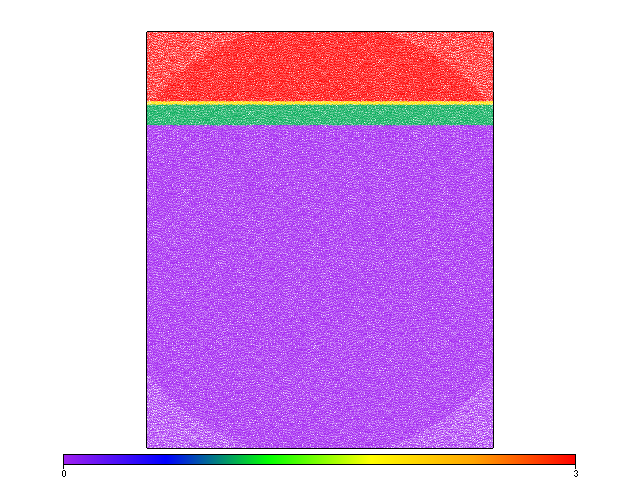

In [26]:
#figtemp = plt.Figure()
#tempminmax = fn.view.min_max(temperatureField)
#figtemp.Surface(temperatureField, linearMesh)
#figtemp.VectorArrows(velocityField, linearMesh, lengthScale=0.5/velmax, arrowHeadSize=0.2 )
#figtemp.Points( swarm=gSwarm, colourVariable=materialVariable , pointSize=1.0)
#figtemp.Mesh(linearMesh, colourBar=False)
#figtemp.show()
#figtemp.save_database('test.gldb')

##Set the values for the masking swarms

In [27]:
#Setup up a masking Swarm variable for the integrations.
#Two possible problems? 
#does it work in parallel,
#How do we mange advecting this swarm?
#(might be best to just rebuild it every timestep, that way we only focus on advecting the material swarm)

rockIntVar.data[:] = 0.
notair = np.where(materialVariable.data != airIndex)
rockIntVar.data[notair] = 1.

airIntVar.data[:] = 0.
notrock = np.where(materialVariable.data == airIndex)
airIntVar.data[notrock] = 1.

lithIntVar.data[:] = 0.
islith = np.where((materialVariable.data == lithosphereIndex) | (materialVariable.data == crustIndex))
lithIntVar.data[islith] = 1.

##Set up a swarm for surface integrations¶


In [27]:
snum = 1000.
elsize = (linearMesh.data[:,0].max()- linearMesh.data[:,0].min())/linearMesh.elementRes[0]
dx = (linearMesh.data[:,0].max()- linearMesh.data[:,0].min())/snum
yp = 1. - elsize/2.

linearMesh.data[:,0].max()
xps = np.linspace(linearMesh.data[:,0].min(),linearMesh.data[:,0].max(), snum)
yps = [yp for i in xps]

surfintswarm = uw.swarm.Swarm( feMesh=elementMesh )
dumout = surfintswarm.add_particles_with_coordinates(np.array((xps,yps)).T)

yps = [(elsize/8.) for i in xps]

baseintswarm = uw.swarm.Swarm( feMesh=elementMesh )
dumout = baseintswarm.add_particles_with_coordinates(np.array((xps,yps)).T)

In [28]:
print(1. - (2*dz), yp) 

(0.9653979238754326, 0.99609375)


In [29]:
# visualise
#fig1 = plt.Figure()
#fig1.Points( swarm=surfintswarm, pointSize=10.0)
#fig1.Points( swarm=baseintswarm, pointSize=10.0)
#fig1.Points( swarm=gSwarm,colourVariable=rockIntVar)
#fig1.VectorArrows(velocityField, linearMesh, lengthScale=0.0002)
#fig1.Surface(temperatureField, linearMesh)
#
#fig1.Mesh(linearMesh, colourBar=False)
#fig1.show()

#Material properties


In [30]:
#Make variables required for plasticity

secinvCopy = fn.tensor.second_invariant( 
                    fn.tensor.symmetric( 
                        velocityField.gradientFn ))

coordinate = fn.input()

depth = 1. - coordinate[1]


In [31]:
depthField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1 )

depthField.data[:] = depth.evaluate(linearMesh)
depthField.data[np.where(depthField.data[:] < 0.)[0]] = 0.
#depthdata = depth.evaluate(linearMesh)

In [32]:

viscosityl2 = newvisc*fn.math.exp((math.log(ETA_T)*-1*temperatureField) + (depthField*math.log(ETA_Y)))

viscosityFn1 = viscosityl2 #This one always gets passed to the first velcotity solve

#Von Mises effective viscosity
viscosityp = ETA0 + YSTRESS/(secinvCopy/math.sqrt(0.5)) #extra factor to account for underworld second invariant form


viscosityFn2 = 2./(1./viscosityl2 + 1./viscosityp)


In [33]:
#RAc = (g*-3300*((Dr*1000)**3))/((eta0*kappa))

airviscosity = 0.005*viscosityl2.evaluate(linearMesh).min()
airdensity = RA*10

In [34]:
print(ETA_T, ETA_Y, ETA0, YSTRESS)

(100000.0, 10, 0.4466835921509633, 446.6835921509633)


Set up simulation parameters and functions
====

Here the functions for density, viscosity etc. are set. These functions and/or values are preserved for the entire simulation time. 

In [35]:
# Here we set a viscosity value of '1.' for both materials
viscosityMapFn = fn.branching.map( keyFunc = materialVariable,
                         mappingDict = {airIndex:airviscosity, lithosphereIndex:viscosityFn2, crustIndex:viscosityFn2,mantleIndex:viscosityFn2} )

densityMapFn = fn.branching.map( keyFunc = materialVariable,
                         mappingDict = {airIndex:airdensity, lithosphereIndex:RA*temperatureField, crustIndex:RA*temperatureField, mantleIndex:RA*temperatureField} )

# Define our gravity using a python tuple (this will be automatically converted to a function)
gravity = ( 0.0, 1.0 )

buoyancyFn = gravity*densityMapFn

Build the Stokes system, solvers, advection-diffusion
------

Setup linear Stokes system to get the initial velocity.

In [36]:
#We first set up a l
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
#                              viscosityFn=viscosityFn1, 
                              viscosityFn=fn.exception.SafeMaths(viscosityFn1), 
                              bodyForceFn=buoyancyFn)

We do one solve with linear viscosity to get the initial strain rate invariant. This solve step also calculates a 'guess' of the the velocity field based on the linear system, which is used later in the non-linear solver.

In [37]:
stokesPIC.solve()

In [38]:
# Setup the Stokes system again, now with linear or nonlinear visocity viscosity.
stokesPIC2 = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              viscosityFn=fn.exception.SafeMaths(viscosityMapFn), 
                              bodyForceFn=buoyancyFn )

In [39]:
solver = uw.systems.Solver(stokesPIC2) # altered from PIC2

solver.options.main.Q22_pc_type='uwscale'  # also try 'gtkg', 'gkgdiag' and 'uwscale'
solver.options.main.penalty = 1.0
solver.options.A11.ksp_rtol=1e-6
solver.options.scr.ksp_rtol=1e-5
solver.options.scr.use_previous_guess = True
solver.options.scr.ksp_set_min_it_converge = 1
solver.options.scr.ksp_set_max_it = 100
solver.options.mg.levels = 5
solver.options.mg.mg_levels_ksp_type = 'chebyshev'
solver.options.mg_accel.mg_accelerating_smoothing = True
solver.options.mg_accel.mg_accelerating_smoothing_view = False
solver.options.mg_accel.mg_smooths_to_start = 1

Solve for initial pressure and velocity using a quick non-linear Picard iteration


In [40]:
solver.solve(nonLinearIterate=True)

Create an advective-diffusive system
=====

Setup the system in underworld by flagging the temperature and velocity field variables.

In [41]:
#Create advdiff system
advDiff = uw.systems.AdvectionDiffusion( temperatureField, velocityField, diffusivity=1., conditions=[tempBC,] )

advector = uw.systems.SwarmAdvector( swarm=gSwarm, velocityField=velocityField, order=2)

Metrics for benchmark
=====

Define functions to be used in the time loop. For cases 1-4, participants were asked to report a number of diagnostic quantities to be measured after reaching steady state:

* Average temp... $$  \langle T \rangle  = \int^1_0 \int^1_0 T \, dxdy $$
* Top and bottom Nusselt numbers... $$N = \int^1_0 \frac{\partial T}{\partial y} \rvert_{y=0/1} \, dx$$
* RMS velocity over the whole domain, surface and max velocity at surface
* max and min viscosity over the whole domain
* average rate of work done against gravity...$$\langle W \rangle = \int^1_0 \int^1_0 T u_y \, dx dy$$
* and the average rate of viscous dissipation...$$\langle \Phi \rangle = \int^1_0 \int^1_0 \tau_{ij} \dot \epsilon_{ij} \, dx dy$$

* In steady state, if thermal energy is accurately conserved, the difference between $\langle W \rangle$ and $\langle \Phi \rangle / Ra$ must vanish, so also reported is the percentage error: 

$$ \delta = \frac{\lvert \langle W \rangle - \frac{\langle \Phi \rangle}{Ra} \rvert}{max \left(  \langle W \rangle,  \frac{\langle \Phi \rangle}{Ra}\right)} \times 100% $$

In [42]:
#Setup some Integrals. We want these outside the main loop...
tempVariable = gSwarm.add_variable( dataType="double", count=1 )
tempVariable.data[:] = temperatureField.evaluate(gSwarm)[:]
tempint = uw.utils.Integral((tempVariable*rockIntVar), linearMesh)


areaint = uw.utils.Integral((1.*rockIntVar),linearMesh)

v2int = uw.utils.Integral(fn.math.dot(velocityField,velocityField)*rockIntVar, linearMesh)


dwint = uw.utils.Integral(temperatureField*velocityField[1]*rockIntVar, linearMesh)

secinv = fn.tensor.second_invariant(
                    fn.tensor.symmetric(
                        velocityField.gradientFn ))

sinner = fn.math.dot(secinv,secinv)
vdint = uw.utils.Integral((4.*viscosityFn2*sinner)*rockIntVar, linearMesh)
vdintair = uw.utils.Integral((4.*viscosityFn2*sinner)*airIntVar, linearMesh)
vdintlith = uw.utils.Integral((4.*viscosityFn2*sinner)*lithIntVar, linearMesh)

In [43]:
def avg_temp():
    return tempint.evaluate()[0]

#This one gets cleaned up when Surface integrals are available
def nusselt(tempfield, swarm, dx):
    #Update the swarm variable
    tempgrad = tempfield.gradientFn
    valcheck = tempgrad[1].evaluate(swarm)
    if valcheck is None:
        vals = np.array(0, dtype='float64')
    else:
        vals = valcheck.sum()*dx
    return vals

def rms():
    return math.sqrt(v2int.evaluate()[0])

#This one gets cleaned up when Surface integrals are available
def rms_surf(swarm, dx):
    rmsmaxfn = fn.math.sqrt(fn.math.dot(velocityField,velocityField))
    rmscheck = rmsmaxfn.evaluate(swarm)
    if rmscheck is None:
        rmsvals = np.array(0, dtype='float64')
    else:
        rmsvals = rmscheck.sum()*dx
    return rmsvals

def max_vx_surf(velfield, swarm):
    surfvelxmaxfn = fn.view.min_max(velfield[0])
    surfvelxmaxfn.evaluate(swarm)
    return surfvelxmaxfn.max_global()

def max_vy_surf(velfield, swarm):
    surfvelxmaxfn = fn.view.min_max(velfield[1])
    surfvelxmaxfn.evaluate(swarm)
    return surfvelxmaxfn.max_global()

def gravwork(workfn):
    return workfn.evaluate()[0]

def viscdis(vdissfn):
    return vdissfn.evaluate()[0]

def visc_extr(viscfn):
    vuviscfn = fn.view.min_max(viscfn)
    vuviscfn.evaluate(linearMesh)
    return vuviscfn.max_global(), vuviscfn.min_global()

In [44]:
#Fields for saving data / fields

rmsField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1)
rmsfn = fn.math.sqrt(fn.math.dot(velocityField,velocityField))
rmsdata = rmsfn.evaluate(linearMesh)
rmsField.data[:] = rmsdata 

viscField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1)
viscdata = viscosityFn2.evaluate(linearMesh)
viscField.data[:] = viscdata


stressField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1)
srtdata = fn.tensor.second_invariant( 
                    fn.tensor.symmetric( 
                        velocityField.gradientFn ))
rostfield = srtdata.evaluate(linearMesh)
stressinv = 2*viscdata*rostfield[:]
stressField.data[:] = stressinv



##Gldbs:

viscVariable = gSwarm.add_variable( dataType="float", count=1 )
viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)
figEta = plt.Figure()
figEta.Points(gSwarm,viscVariable)
figEta.Points(gSwarm,materialVariable, colours='brown white red blue')

Main simulation loop
=======

The main time stepping loop begins here. Before this the time and timestep are initialised to zero and the output statistics arrays are set up. Also the frequency of outputting basic statistics to the screen is set in steps_output.


In [45]:
realtime = 0.
step = 0
timevals = [0.]
steps_end = 5
steps_display_info = 20
swarm_update = np.floor(10.*RES/64)
files_output = 200
gldbs_output = 500
checkpoint_every = 10000

In [46]:
def checkpoint(step, path):
    velfile = "velocityField" + str(step) + ".hdf5"
    pressfile = "pressureField" + str(step) + ".hdf5"
    swarmfile = "materialSwarm" + str(step) + ".hdf5"
    velocityField.save(os.path.join(path, velfile))
    pressureField.save(os.path.join(path, pressfile))
    gSwarm.save(os.path.join(path, swarmfile))

In [47]:
# initialise timer for computation
start = time.clock()
# setup summary output file (name above)
f_o = open(outputPath+outputFile, 'w')
# Perform steps
while realtime < 0.15:
#while step < steps_end:
#while step < 3:
    #Enter non-linear loop
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    advDiff.integrate(dt)
    # Advect swarm using this timestep size
    advector.integrate(dt)
    # Increment
    realtime += dt
    step += 1
    timevals.append(realtime)
    #Update any swarm variables and temperature field in the air region
    tempVariable.data[:] = temperatureField.evaluate(gSwarm)[:]
    for index, coord in enumerate(linearMesh.data):
        if coord[1] >= (1 + 1.5*(yelsize)):
            temperatureField.data[index] = 0.   
    # Calculate the Metrics, only on 1 of the processors:
    tempVariable.data[:] = temperatureField.evaluate(gSwarm)[:]
    Avg_temp = avg_temp()
    Rms = rms()
    Max_vx_surf = max_vx_surf(velocityField, surfintswarm)
    Gravwork = gravwork(dwint)
    Viscdis = viscdis(vdint)
    Viscdisair = viscdis(vdintair)
    Viscdislith = viscdis(vdintlith)
    etamax, etamin = visc_extr(viscosityFn2)
    #These are the ones that need mpi4py treatment
    Nu0loc = nusselt(temperatureField, baseintswarm, dx)
    Nu1loc = nusselt(temperatureField, surfintswarm, dx)
    Rmsurfloc = rms_surf(surfintswarm, dx)
    #Setup the global output arrays
    dTp = Nu0loc.dtype
    Nu0glob = np.array(0, dtype=dTp)
    dTp = Nu1loc.dtype
    Nu1glob = np.array(0, dtype=dTp)
    dTp = Rmsurfloc.dtype
    Rmsurfglob = np.array(0, dtype=dTp)
    #Do global sum
    comm.Allreduce(Nu0loc, Nu0glob, op=MPI.SUM)
    comm.Allreduce(Nu1loc, Nu1glob, op=MPI.SUM)
    comm.Allreduce(Rmsurfloc, Rmsurfglob, op=MPI.SUM)
    # output to summary text file
    if uw.rank()==0:
        f_o.write((13*'%-15s ' + '\n') % (realtime, Viscdis, float(Nu0glob), float(Nu1glob), Avg_temp, 
                                          Rms,Rmsurfglob,Max_vx_surf,Gravwork, etamax, etamin, Viscdisair, Viscdislith))
    #if step %  steps_display_info == 0:
    # output image to file
    if (step % files_output == 0) & (writeFiles == True):
        ##Files to save
        fnametemp = "temperatureField" + "_" + str(ModIt) + "_" + str(step) + ".hdf5"
        fullpath = os.path.join(outputPath + "files/" + fnametemp)
        temperatureField.save(fullpath)
        #RMS
        fnamerms = "rmsField" + "_" + str(ModIt) + "_" + str(step) + ".hdf5"
        fullpath = os.path.join(outputPath + "files/" + fnamerms)
        rmsField.save(fullpath)
     
    if (step % gldbs_output == 0) & (writeFiles == True):
        fnamedb = "viscFig" + "_" + str(ModIt) + "_" + str(step) + ".gldb"
        fullpath = os.path.join(outputPath + "gldbs/" + fnamedb)
        figEta.save_database(fullpath)
    ################
    #Particle update
    ###############
    particledepths = 1. - gSwarm.particleCoordinates.data[:,1]
    particletemps = temperatureField.evaluate(gSwarm)[:,0]
    conditionmap['depthcondition']['data'] = particledepths
    conditionmap['avgtempcondition']['data'] = particletemps
    if step % swarm_update == 0:
        number_updated = 0
        for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
            check = update_swarm(DG, particleID)
            if check > -1:
                number_updated += 1
                #if check == 0:
                #    print "from " + str(materialVariable.data[particleID]) + " to " + str(check)
                materialVariable.data[particleID] = check
            else:
                pass
        print("Total Particles updated is: " + str(number_updated))
        #Also update those integration swarms
        rockIntVar.data[:] = 0.
        notair = np.where(materialVariable.data != airIndex)
        rockIntVar.data[notair] = 1.
        airIntVar.data[:] = 0.
        notrock = np.where(materialVariable.data == airIndex)
        airIntVar.data[notrock] = 1.
        lithIntVar.data[:] = 0.
        islith = np.where((materialVariable.data == lithosphereIndex) | (materialVariable.data == crustIndex))
        lithIntVar.data[islith] = 1.
        #Also print some info at this step increment
        print('steps = {0:6d}; time = {1:.3e}; v_rms = {2:.3f}; Nu0 = {3:.3f}; Nu1 = {3:.3f}'
          .format(step, realtime, Rms, float(Nu0glob), float(Nu1glob)))
        
f_o.close()
checkpoint(step, checkpointPath)

In [48]:
#vdfield = densityMapFn
#vdVariable = gSwarm.add_variable( dataType="float", count=1)
#vd = vdfield.evaluate(gSwarm)
#vdVariable.data[:] = vd[:]

#fig1 = plt.Figure()
#fig1.Surface(buoyancyFn[1], elementMesh)
#fig1.Surface(velocityField[1], elementMesh)
#fig1.Points( swarm=gSwarm, colourVariable=vdVariable , pointSize=3.0)
#fig1.VectorArrows(velocityField, linearMesh, lengthScale=0.1)
#fig1.show()

In [49]:
#fig1 = plt.Figure()
#fig1.Surface(buoyancyFn[1], elementMesh)
#fig1.Surface(depthField, elementMesh, colours='blue white brown')
#fig1.Points( swarm=gSwarm, colourVariable=materialVariable , pointSize=1.0, colours='white red black')
#fig1.Points( swarm=gSwarm, colourVariable=rockIntVar, pointSize=1.0)

#fig1.VectorArrows(velocityField, linearMesh, lengthScale=0.02)
#fig1.show()

In [50]:
print(time.clock()-start, realtime)

(128.533867, 3.0517578125e-05)


In [51]:
#visplot = viscosityMapFn.evaluate(linearMesh)

In [52]:
#viscVariable = gSwarm.add_variable( dataType="float", count=1 )
#viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)
#figEta = plt.Figure()
#figEta.Points(gSwarm,viscVariable, colours='brown white red blue')
#figEta.VectorArrows(velocityField, linearMesh, lengthScale=0.002)
#figEta.Points(gSwarm,materialVariable, colours='brown white red blue')
#figEta.Points(gSwarm,materialVariable)
#figEta.show()